In [9]:
import zipfile
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt


## 读取zip file

In [ ]:
zip_file = '/storage1/jiaorushi/20240116Rushi/MD/Simulation NSCLC DICOM/LUP409.zip'
import zipfile
from pydicom import dcmread
from pydicom.sequence import Sequence

def extract_dicom_sequences(zip_path):
    sequences = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # 获取ZIP文件中的所有文件名称
        file_list = zip_ref.namelist()
        dicom_files = [file_name for file_name in file_list if file_name.endswith('.dcm')]
        
        # 按序列分组
        for dicom_file in dicom_files:
            with zip_ref.open(dicom_file, 'r') as file:
                dcm = dcmread(file)
                # 检查是否已经在某个序列中
                found_in_sequence = False
                for seq in sequences:
                    if seq[0] == dcm.SeriesInstanceUID:
                        seq[1].append(dcm)
                        found_in_sequence = True
                        break
                if not found_in_sequence:
                    # 创建新的序列
                    sequences.append([dcm.SeriesInstanceUID, [dcm]])
    
    return sequences

# 替换下面的'your_zip_file.zip'为你的ZIP文件路径
zip_file_path = '/storage1/jiaorushi/20240116Rushi/MD/Simulation NSCLC DICOM/LUP850.zip'
sequences = extract_dicom_sequences(zip_file_path)

# 打印结果
for seq in sequences:
    if seq[1][0].SeriesDescription == '90.0%':
        sorted_datasets = sorted(seq[1], key=lambda x: float(x[0x0020, 0x0032][-1]), reverse=True)
        print(len(sorted_datasets))
        array = np.empty((0,) + sorted_datasets[0].pixel_array.shape, dtype=sorted_datasets[0].pixel_array.dtype)

        for ds in sorted_datasets:
            z_spacing = ds[0x0020, 0x0032]
            z = ds[0x0018, 0x0088] 
            xy = ds[0x0028, 0x0030] 
            print(z, xy, z_spacing)
            array = np.vstack((array, ds.pixel_array[np.newaxis]))
        print(ds)



In [ ]:
print(array.shape, np.amax(array), np.amin(array))
# array[array>2000] = 2000
# array[array<1500] = 1500
for i in range(1,100,10):
    plt.figure()
    plt.imshow(array[i], cmap='gray')

## 肺实质阈值获取掩码

In [ ]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
from glob import glob
img = array[100] # 以一张切片为例
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std

i=100
image_array = array[i]
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,8))
ax1.imshow(image_array,cmap='gray')
plt.hist(img.flatten(),bins=200)
plt.show()


In [ ]:
#提取肺部大致均值
middle = img[100:400,100:400]  
mean = np.mean(middle)  

# 将图片最大值和最小值替换为肺部大致均值
max = np.max(img)
min = np.min(img)
print(mean,min,max)
img[img==max]=mean
img[img==min]=mean


image_array = img
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,8))
ax1.imshow(image_array,cmap='gray')
ax2.hist(img.flatten(),bins=200)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)  
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
print('kmean centers:',centers)
print('threshold:',threshold)
'''
kmean centers: [-0.2307924288649088, 1.472218336483015]
threshold: 0.6207129538090531
'''
# 聚类完成后，清晰可见偏黑色区域为一类，偏灰色区域为另一类。
image_array = thresh_img
plt.imshow(image_array,cmap='gray') 
plt.show()

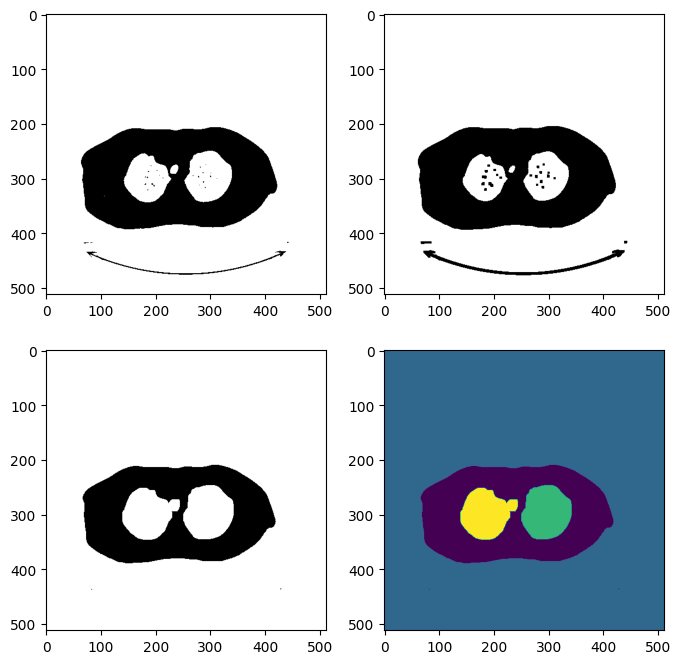

In [60]:
eroded = morphology.erosion(thresh_img,np.ones([4,4]))  
dilation = morphology.dilation(eroded,np.ones([10,10]))  
labels = measure.label(dilation)   
fig,ax = plt.subplots(2,2,figsize=[8,8])
ax[0,0].imshow(thresh_img,cmap='gray')  
ax[0,1].imshow(eroded,cmap='gray') 
ax[1,0].imshow(dilation,cmap='gray')  
ax[1,1].imshow(labels)  # 标注mask区域切片图
plt.show()

In [ ]:
label_vals = np.unique(labels)
# thresh_img = thresh_img.astype('uint8')
regions = measure.regionprops(labels) # 获取连通区域

# 设置经验值，获取肺部标签
good_labels = []
for prop in regions:
    area = prop.area
    print(area)
    if 1:
        B = prop.bbox
        print(B)
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
'''
(0L, 0L, 512L, 512L)
(190L, 253L, 409L, 384L)
(200L, 110L, 404L, 235L)
'''
# 根据肺部标签获取肺部mask，并再次进行’膨胀‘操作，以填满并扩张肺部区域
mask = np.ndarray([512,512],dtype=np.int8)
mask[:] = 0
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
#imgs_to_process[i] = mask
fig,ax = plt.subplots(2,2,figsize=[10,10])
ax[0,0].imshow(img)  # CT切片图
ax[0,1].imshow(img,cmap='gray')  # CT切片灰度图
ax[1,0].imshow(mask,cmap='gray')  # 标注mask，标注区域为1，其他为0
ax[1,1].imshow(img*mask,cmap='gray')  # 标注mask区域切片图
plt.show()

## 读取私有数据集

In [100]:
import os
import glob
def extract_dicom_sequences(patient_path):
    sequences = []
    file_list = glob.glob(patient_path + '/*.dcm')
    dicom_files = [file_name for file_name in file_list if file_name.split('/')[-1].startswith('CT.')]
    
    # 按序列分组
    for dicom_file in dicom_files:
        dcm = dcmread(dicom_file)
        # 检查是否已经在某个序列中
        found_in_sequence = False
        for seq in sequences:
            if seq[0] == dcm.SeriesInstanceUID:
                seq[1].append(dcm)
                found_in_sequence = True
                break
        if not found_in_sequence:
            # 创建新的序列
            sequences.append([dcm.SeriesInstanceUID, [dcm]])
    return sequences

# 替换下面的'your_zip_file.zip'为你的ZIP文件路径
zip_file_path = '/storage1/jiaorushi/20240116Rushi/Stanford/LUNG_139/98/'
sequences = extract_dicom_sequences(zip_file_path)

# 打印结果
for seq in sequences:
    print(seq[1][0].SeriesNumber)
    if seq[1][0].SeriesNumber == 9:
        sorted_datasets = sorted(seq[1], key=lambda x: float(x[0x0020, 0x0032][-1]), reverse=True)
        array = np.empty((0,) + sorted_datasets[0].pixel_array.shape, dtype=sorted_datasets[0].pixel_array.dtype)
        for ds in sorted_datasets:
            array = np.vstack((array, ds.pixel_array[np.newaxis]))
        print(array.shape)
        print(ds)
        z_spacing = abs(sorted_datasets[0][0x0020, 0x0032][2] - sorted_datasets[1][0x0020, 0x0032][2])
        print(z_spacing)
        print(sorted_datasets[0][0x0028, 0x0030])

9
(218, 512, 512)
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 184
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.246.352.221.52334061147510954742784458784117370011
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.160.3
(0002, 0013) Implementation Version Name         SH: 'DCIE 2.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20201130'
(0008, 0013) Instance Creation Time              TM: '201757'
(0008, 0016) SOP Class UID                       UI: CT Image Storag

In [ ]:
import skimage
def respacing(ct_image, original_spacing, new_spacing):
    # z, x, y
    new_shape = np.round(np.array(ct_image.shape) * np.array(original_spacing) / np.array(new_spacing)).astype(int)
    ct_image = skimage.transform.resize(ct_image, new_shape, 1)
    return ct_image

original_spacing =  list(sorted_datasets[0][0x0028, 0x0030])
original_spacing.insert(0, z_spacing)
original_spacing = [float(s) for s in original_spacing]
new_array = respacing(array, original_spacing, [1,1,1])
print(original_spacing)
print(new_array.shape)
plt.figure()
plt.imshow(new_array[0], cmap='gray')
plt.figure()
plt.imshow(new_array[100], cmap='gray')
plt.figure()
plt.imshow(new_array[200], cmap='gray')
plt.figure()
plt.imshow(new_array[300], cmap='gray')


In [1]:
import zipfile
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import zipfile
from pydicom import dcmread
from pydicom.sequence import Sequence
import glob
import skimage
from get_lung_mask import lung_mask
import os

def zip_extract_dicom_sequences(zip_path):
    sequences = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # 获取ZIP文件中的所有文件名称
        file_list = zip_ref.namelist()
        dicom_files = [file_name for file_name in file_list if file_name.endswith('.dcm')]
        
        # 按序列分组
        for dicom_file in dicom_files:
            with zip_ref.open(dicom_file, 'r') as file:
                dcm = dcmread(file)
                # 检查是否已经在某个序列中
                found_in_sequence = False
                for seq in sequences:
                    if seq[0] == dcm.SeriesInstanceUID:
                        seq[1].append(dcm)
                        found_in_sequence = True
                        break
                if not found_in_sequence:
                    # 创建新的序列
                    sequences.append([dcm.SeriesInstanceUID, [dcm]])
    return sequences

def respacing(ct_image, mask, original_spacing, new_spacing):
    # z, x, y
    new_shape = np.round(np.array(ct_image.shape) * np.array(original_spacing) / np.array(new_spacing)).astype(int)
    ct_image = skimage.transform.resize(ct_image, new_shape, 1)
    new_mask = skimage.transform.resize(mask, new_shape, 0, anti_aliasing=False)
    print(np.amax(ct_image), np.amax(new_mask))
    ct_image = ((ct_image-np.amin(ct_image))*255/(np.amax(ct_image)-np.amin(ct_image))).astype('uint8') 
    new_mask = ((new_mask-np.amin(new_mask))*1/(np.amax(new_mask)-np.amin(new_mask))).astype('uint8') 
    print(np.amax(ct_image), np.amax(new_mask))
    return ct_image, new_mask

def save_nii(array, save_path):
    dcm = sitk.GetImageFromArray(array)
    sitk.WriteImage(dcm, save_path)


if __name__ == '__main__':
    zip_files = glob.glob('/storage1/jiaorushi/20240116Rushi/MD/Simulation NSCLC DICOM/'+'/*.zip')
    save_path = '/storage1/jiaorushi/20240116Rushi/MD/preprocessed/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    zip_num = 0
    seq_num = 0
    for zip_file_path in zip_files:
        zip_num += 1
        sequences = zip_extract_dicom_sequences(zip_file_path)
        save_file = save_path + zip_file_path.split('/')[-1].split('.')[0]
        for seq in sequences:
            try:
                if seq[1][0].SeriesDescription == '90.0%':
                    seq_num += 1
                    sorted_datasets = sorted(seq[1], key=lambda x: float(x[0x0020, 0x0032][-1]), reverse=True)
                    array = np.empty((0,) + sorted_datasets[0].pixel_array.shape, dtype=sorted_datasets[0].pixel_array.dtype)
                    for ds in sorted_datasets:
                        array = np.vstack((array, ds.pixel_array[np.newaxis]))
                    z = ds[0x0018, 0x0088].value
                    xy = list(ds[0x0028, 0x0030])
                    xy.insert(0, z)
                    xy = [float(s) for s in xy]

                    mask_all = []
                    for image in array:
                        mask = lung_mask(image)
                        mask_all.append(mask)
                    mask_all = np.array(mask_all)
                    new_array, new_mask_all = respacing(array, mask_all, xy, [1,1,1])
                    print(save_file, array.shape, xy, new_array.shape, new_mask_all.shape)
                    save_img = save_file + '_image.nii'
                    save_mask = save_file + '_mask.nii'
                    plt.figure()
                    plt.imshow(new_array[0], cmap='gray')
                    plt.figure()
                    plt.imshow(new_array[-1], cmap='gray')
                    plt.figure()
                    plt.imshow(new_mask_all[0], cmap='gray')
                    plt.figure()
                    plt.imshow(new_mask_all[-1], cmap='gray')
                    save_nii(new_array, save_img)
                    save_nii(new_mask_all, save_mask)
            except:
                print(save_file)
    print(zip_num, seq_num)









/home/sjtu/anaconda3/envs/pytorch_jrs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sjtu/anaconda3/envs/pytorch_jrs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sjtu/anaconda3/envs/pytorch_jrs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sjtu/anaconda3/envs/pytorch_jrs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

0.050517947204810384 1
255 1
/storage1/jiaorushi/20240116Rushi/MD/preprocessed/LUP409 (141, 512, 512) [2.5, 1.03515625, 1.03515625] (352, 530, 530) (352, 530, 530)
/storage1/jiaorushi/20240116Rushi/MD/preprocessed/LUP409


/home/sjtu/anaconda3/envs/pytorch_jrs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sjtu/anaconda3/envs/pytorch_jrs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sjtu/anaconda3/envs/pytorch_jrs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sjtu/anaconda3/envs/pytorch_jrs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t